# Solving portfolio optimization as QUBO problem with QAOA

## Overview

Here we show how to solve a quadratic unconstrained binary optimization (QUBO) problem using QAOA.  Later on below we will extend this to show how to solve binary Markowitz portfolio optimization problems.

## QUBO problem

### what is QUBO?

Quadratic unconstrained binary optimization (QUBO) is a type of problem that aims to optimize a quadratic objective function using binary variables. In a QUBO problem, the objective is to find the binary variable assignments that minimize or maximize the quadratic objective function. These variables represent choices or decision variables that can be either selected (1) or not selected (0). The objective function reflects the associated costs, benefits, or constraints linked to these decisions.

QUBO is a NP-hard problem.

### An example

We illustrate the QUBO problem with a simple example. Consider minimizing the following 2x2 QUBO objective function:

$\begin{pmatrix}x_1 & x_2\end{pmatrix}\begin{pmatrix}-5& -2 \\-2 & 6\end{pmatrix}\begin{pmatrix}x_1\\x_2\end{pmatrix} = -5x_1^2 -4x_1x_2 +6x_2^2$

Clearly this is minimized at $(x_1,x_2) = (1,0)$, with corresponding objective function value of $-5$

We first convert this to an Ising Hamiltonian by mapping $x_i\rightarrow \frac{I-Z_i}{2}$

This gives

$$-\frac{5}{4}(I-Z_1)^2 -\frac{4}{4}(I-Z_1)(I-Z_2) + \frac{6}{4}(I-Z_2)^2 $$

which simplifies to

$$-\frac{1}{2}I +\frac{7}{2}Z_1   -2Z_2 -Z_1Z_2$$ 

The $-I/2$ term is simply a constant offset, so we can solve the problem by finding the minimum of 

$$\langle \psi | \frac{7}{2}Z_1 -2Z_2 -Z_1Z_2 |\psi\rangle$$ 

Note that the minimum should correspond to the computational basis state $|10\rangle$, and the corresponding true objective function value should be $-4.5$ (ignoring the offset value of $-1/2$)

## Setup

In [7]:
import tensorcircuit as tc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from functools import partial
import time
import scipy.optimize as optimize

In [8]:
K = tc.set_backend("tensorflow")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

nlayers = 2
states = []
for i in range(4):
    states.append(f"{bin(i)[2:]:0>{2}}")

# see below for a function to generate the pauli terms and weights from the QUBO matrix

### Convert the Q-matrix to Ising Hamiltonian

In [9]:
def QUBO_to_Ising(Q):
    # input is n-by-n symmetric numpy array corresponding to Q-matrix
    # output is the components of Ising Hamiltonian

    n = Q.shape[0]

    offset = np.triu(Q, 0).sum() / 2
    pauli_terms = []
    weights = -np.sum(Q, axis=1) / 2

    for i in range(n):
        term = np.zeros(n)
        term[i] = 1
        pauli_terms.append(term)

    for i in range(n - 1):
        for j in range(i + 1, n):
            term = np.zeros(n)
            term[i] = 1
            term[j] = 1
            pauli_terms.append(term)

            weight = Q[i][j] / 2
            weights = np.concatenate((weights, weight), axis=None)

    return pauli_terms, weights, offset


In [10]:
Q = np.array([[-5, -2], [-2, 6]])
pauli_terms, weights, offset = QUBO_to_Ising(Q)
print("The pauli terms in this QUBO problem are: ", pauli_terms)
print("and correspond weights are:", weights)
print("the offset is:", offset)

The pauli terms in this QUBO problem are:  [array([1., 0.]), array([0., 1.]), array([1., 1.])]
and correspond weights are: [ 3.5 -2.  -1. ]
the offset is: -0.5


The results are consistent with our analysis.

### Ansatz

In [11]:
# Now we define the QAOA ansatz of depth nlayers
def QAOA_from_Ising(params, nlayers, pauli_terms, weights):
    nqubits = len(pauli_terms[0])
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.h(i)
    for j in range(nlayers):
        # cost term
        for k in range(len(pauli_terms)):
            term = pauli_terms[k]
            index_of_ones = []
            for l in range(len(term)):
                if term[l] == 1:
                    index_of_ones.append(l)
            if len(index_of_ones) == 1:
                c.rz(index_of_ones[0], theta=2 * weights[k] * params[2 * j])
            elif len(index_of_ones) == 2:
                c.exp1(
                    index_of_ones[0],
                    index_of_ones[1],
                    unitary=tc.gates._zz_matrix,
                    theta=weights[k] * params[2 * j],
                )
            else:
                raise ValueError("Invalid number of Z terms")

        for i in range(nqubits):
            c.rx(i, theta=params[2 * j + 1])  # mixing terms
    return c


### Loss function

For a general state that is the output of a quantum circuit c, we first define the corresponding loss with respect to the Ising Hamiltonian.

In [12]:
def Ising_loss(c, pauli_terms, weights):
    loss = 0.0
    for k in range(len(pauli_terms)):
        term = pauli_terms[k]
        index_of_ones = []

        for l in range(len(term)):
            if term[l] == 1:
                index_of_ones.append(l)

        if len(index_of_ones) == 1:
            delta_loss = weights[k] * c.expectation_ps(z=[index_of_ones[0]])

        else:
            delta_loss = weights[k] * c.expectation_ps(
                z=[index_of_ones[0], index_of_ones[1]]
            )

        loss += delta_loss

    return K.real(loss)


In [13]:
def Ising_loss_Q(c, Q):
    n_qubits = c._nqubits
    prob = c.probability()
    loss = 0.0
    for i in range(len(prob)):
        state = f"{bin(i)[2:]:0>{n_qubits}}"
        x = np.array([int(bit) for bit in state])
        loss += np.dot(x, np.dot(Q, x)) * prob[i]
        print(loss)
    return K.real(loss)

For the particular case of a circuit corresponding to a QAOA ansatz this is:

In [14]:
def QAOA_loss(nlayers, pauli_terms, weights, params):
    c = QAOA_from_Ising(params, nlayers, pauli_terms, weights)
    return Ising_loss(c, pauli_terms, weights)


In [15]:
def QAOA_loss_Q(nlayers, pauli_terms, weights, Q, params):
    c = QAOA_from_Ising(params, nlayers, pauli_terms, weights)
    return Ising_loss_Q(c, Q)


In [44]:
def QUBO_QAOA(Q, ansatz, nlayers, iterations):
    pauli_terms, weights, offset = QUBO_to_Ising(Q)
    learning_rate = 1e-2

    loss_val_grad = K.value_and_grad(partial(ansatz, nlayers, pauli_terms, weights))
    loss_val_grad_jit = K.jit(loss_val_grad)

    opt = K.optimizer(tf.keras.optimizers.Adam(learning_rate))

    params = K.implicit_randn(shape=[2 * nlayers], stddev=0.5)
    for i in range(iterations):
        loss, grads = loss_val_grad_jit(params)
        params = opt.update(grads, params)

    return params

### Results

In [17]:
iterations = 500
time_start = time.time()
final_params = QUBO_QAOA(Q, QAOA_loss, nlayers, iterations)
clear_output(wait=True)
time_end = time.time()
print("time consumed:", round(time_end - time_start, 4), "s")

time consumed: 6.2393 s


In [18]:
c = QAOA_from_Ising(final_params, nlayers, pauli_terms, weights)
probs = K.numpy(c.probability()).round(decimals=4)
# prob_dict = {states[i]: probs[i] for i in range(4)}
# prob_sorted = dict(sorted(prob_dict.items(), key=lambda item: item[1], reverse=True))
sorted_indices = np.argsort(probs)[::-1]
state_sorted = np.array(states)[sorted_indices]
prob_sorted = np.array(probs)[sorted_indices]

print("\n-------------------------------------")
print("    selection\t  |\tprobability")
print("-------------------------------------")
for i in range(len(states)):
    print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
print("-------------------------------------")


-------------------------------------
    selection	  |	probability
-------------------------------------
        10	  |	  0.7245
        11	  |	  0.1419
        01	  |	  0.0775
        00	  |	  0.0561
-------------------------------------


We note that for nlayers=2 and 500 iterations, the objective function does not in this case (although it depends on the initial parameters) converge to the true value of $-4.5$.  However, the we see below that the final wavefunction does have large overlap with the desired state $|10\rangle$, so measuring the output of the QAOA algorithm will, with high probability, output the correct answer.

In [19]:
def print_output(c):
    n = c._nqubits
    N = 2**n
    x_label = r"$\left|{0:0" + str(n) + r"b}\right>$"
    labels = [x_label.format(i) for i in range(N)]
    plt.bar(range(N), c.probability())
    plt.xticks(range(N), labels, rotation=70)

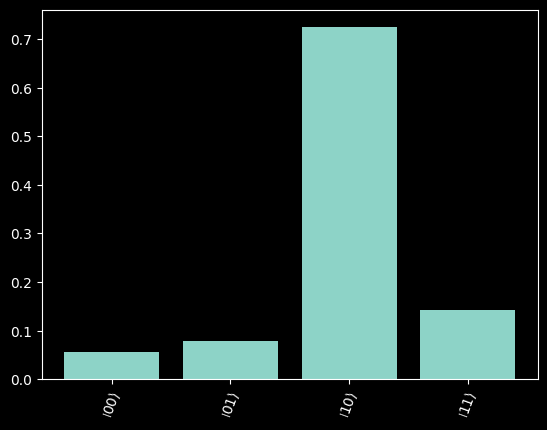

In [20]:
print_output(c)


## General Case

For the general QUBO case, we wish to minimize

$$ x^T Q x$$

where $x\in\{0,1\}^n$ and $Q\in\mathbb{R}^{n\times n}$ is a real symmetric matrix.

This maps to an Ising Hamiltonian 

$$\frac{1}{2}\left(\sum_{i=1}^n C_{ii} + \sum_{i<j}C_{ij}\right) I - \frac{1}{2}\sum_{i=1}^n \left(\sum_{j=1}^n C_{ij} \right)Z_i +\frac{1}{2}\sum_{i<j}C_{ij}Z_iZ_j$$

Below is a simple function which can perform this mapping:

## Portfolio problem

Consider a scenario: Xiaoming, a wise individual, has an amount of money denoted as $B$, and he intends to invest it in the stock market. The market consists of $n$ shares from which he can choose (assuming all shares have the same price). Naturally, Xiaoming aims to maximize returns while minimizing risk. Additionally, it's important to note that individuals have varying levels of risk tolerance. Xiaoming's risk tolerance is denoted as $p$. Given these factors, which shares should Xiaoming select to construct his portfolio?



### Solving portfolio optimization problems with QAOA

In a simple boolean Markowitz portfolio optimization problem, we wish to solve 

$$\min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \mu^T x$$

subject to 

$$ 1^T x = B$$

where 
* $n$: number of assets under consideration
* $q > 0 $: risk-appetite
* $\Sigma \in \mathbb{R}^{n\times n}$: covariance matrix of the assets
* $\mu\in\mathbb{R}^n$: mean return of the assets
* $B$: budget (i.e., total number of assets out of $n$ that can be selected)

Our first step is to convert this constrained quadratic programming problem into a QUBO.  We do this by adding a penalty factor $t$ and consider the alternative problem:

$$ \min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \mu^Tx  + t(1^Tx-B)^2$$

The variables in the linear terms $\mu^Tx = \mu_1 x_1 + \mu_2 x_2+\ldots$ can all be squared (since they are boolean variables), i.e. we can consider

$$\min_{x\in\{0,1\}^n}\quad q x^T \Sigma x - \sum_{i=1}^n\mu_i x_i^2  + t(1^Tx-B)^2$$

which is a QUBO defined by the matrix $Q$ 

$$ Q = q\Sigma -\mu\begin{pmatrix}1 & \\ & 1\\ & & \ddots\end{pmatrix} + t\begin{pmatrix}1 -2B & 1 & \ldots & 1 \\
1 & 1-2B & 1 & \ldots \\1 & 1 & 1-2B \\
\vdots\end{pmatrix}$$

i.e., we wish to mimimize

$$ x^T Q X + tB^2$$

and we ignore the constant term $t B^2$.
We can now solve this by QAOA as above.

Let us first define a function to convert portfolio data into a QUBO matrix:

In [21]:
import datetime
from qiskit_finance.data_providers import RandomDataProvider
num_assets = 5
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()

mu1 = data.get_period_return_mean_vector()
sigma1 = data.get_period_return_covariance_matrix()
print(mu1)
print(sigma1)

[ 0.01528439 -0.00078095  0.00051792  0.00087001  0.01032352]
[[ 2.54138859e-03  7.34022167e-05  1.28600531e-04 -9.98612132e-05
  -3.13199203e-04]
 [ 7.34022167e-05  2.58486713e-04  5.30427595e-05  4.44816208e-05
  -1.32451573e-05]
 [ 1.28600531e-04  5.30427595e-05  7.91504681e-04 -1.23887382e-04
  -9.70273385e-07]
 [-9.98612132e-05  4.44816208e-05 -1.23887382e-04  1.97892585e-04
   8.51533522e-05]
 [-3.13199203e-04 -1.32451573e-05 -9.70273385e-07  8.51533522e-05
   5.43294856e-04]]


In [22]:
class StockData:
    """convert real-world stock data to annualized covariance matrix, annualized return and penalty factor
    input: a list of continuous stock data in the same time span (risk preference & budget for penalty factor)
    output: annualized convariance matrix and return
    """

    def __init__(self, data):
        self.data = data  # add data
        self.n_stocks = len(data)  # num of stocks

        # check the number of days
        n_days = [len(i) for i in data]
        if max(n_days) != (sum(n_days) / len(n_days)):
            raise Exception("timespan of stocks should be the same")
        self.n_days = len(data[1])

        # calculate the daily percentage price change
        self.daily_change = []  # daily percentage price change
        for i in range(self.n_stocks):
            each_stock = [] # the daily change of each stock
            for j in range(self.n_days - 1):
                each_stock.append((data[i][j + 1] - data[i][j]) / data[i][j])
            self.daily_change.append(each_stock)

    # calculate annualized return (mu)
    def get_return(self):
        change = [[i + 1 for i in j] for j in self.daily_change]  # daily_change + 1
        ret = [np.prod(i) ** (252 / self.n_days) for i in change]
        return ret

    # calculate annualized covariance matrix (sigma)
    def get_covariance(self):
        mean_change = [
            [i - np.mean(j) for i in j] for j in self.data
        ]  # daily_change - mean(daily_change)
        cov = 252 / self.n_days * np.dot(mean_change, np.transpose(mean_change))
        return cov

    def get_penalty(self, cov, ret, risk_pre, budget):
        # get all fesible and unfeasible states
        self.f_state = []  # feasible states (num of '1's equal to budge)
        self.uf_state = []  # unfeasible states
        self.all_state = []
        for i in range(2**self.n_stocks):
            state = f"{bin(i)[2:]:0>{self.n_stocks}}"
            n_ones = 0
            for j in state:
                if j == "1":
                    n_ones += 1
            self.all_state.append(state)
            if n_ones == budget:
                self.f_state.append(state)
            else:
                self.uf_state.append(state)

        # determine the penalty factor
        # follow this paper: https://doi.org/10.1007/s11128-022-03766-5 
        mark = False
        penalty = 0  # initial value
        while mark == False:
            R = np.diag(ret)
            S = np.ones((self.n_stocks, self.n_stocks)) - 2 * budget * np.diag(
                np.ones(self.n_stocks)
            )
            Q = risk_pre * cov - R + penalty * S
            F = []
            for state in self.f_state:
                x = np.array([int(bit) for bit in state])
                F.append(np.dot(x, np.dot(Q, x)) + penalty*budget**2)
            Fmin = np.amin(F)
            Fbar = np.mean(F)
            F = []
            for state in self.uf_state:
                x = np.array([int(bit) for bit in state])
                F.append(np.dot(x, np.dot(Q, x)) + penalty*budget**2)
            Fmin_uf = np.amin(F)
            location = np.where(F == Fmin_uf)[0][0]
            if Fmin_uf < 0.5 * (Fmin + Fbar):
                n_ones = 0
                for j in self.uf_state[location]:
                    if j == "1":
                        n_ones += 1
                penalty += (0.5 * (Fmin + Fbar) - Fmin_uf) / (n_ones - budget) ** 2
            else:
                mark = True  # ready to return the penalty
        return penalty

In [23]:
a = [1, 2, 3]
p = np.max(a)
np.nonzero(a == p)[0][0]

2

In [24]:
# real-world stock data, calculated using the functions above
# stock name: aapl, amzn, meta, msft, qcom, sbux
# from 10/06/2022 to 09/06/2023
mu = [
    -1.17343569e-03,
    1.26966979e00,
    4.37331877e-01,
    7.62214894e-02,
    2.32812331e-02,
    8.13555337e-01,
]
sigma = np.array(
    [
        [
            3.88910199e-03,
            -3.02246218e-02,
            2.02613410e-03,
            5.63877561e-04,
            8.31850214e-03,
            1.96669504e-02,
        ],
        [
            -3.02246218e-02,
            1.08394846e02,
            1.35417460e01,
            -2.32832409e-01,
            -2.02572907e-01,
            1.41263456e01,
        ],
        [
            2.02613410e-03,
            1.35417460e01,
            1.20073886e01,
            -9.71260501e-02,
            -4.46005587e-02,
            4.33678217e00,
        ],
        [
            5.63877561e-04,
            -2.32832409e-01,
            -9.71260501e-02,
            1.42552322e00,
            1.65674618e-02,
            -5.65377701e-02,
        ],
        [
            8.31850214e-03,
            -2.02572907e-01,
            -4.46005587e-02,
            1.65674618e-02,
            5.33936214e-02,
            -1.89099328e-02,
        ],
        [
            1.96669504e-02,
            1.41263456e01,
            4.33678217e00,
            -5.65377701e-02,
            -1.89099328e-02,
            3.04928823e01,
        ],
    ]
)
n_stocks = 6  # <= 6
mu = mu[:n_stocks]
sigma = sigma[:n_stocks][:n_stocks]
print(sigma)

[[ 3.88910199e-03 -3.02246218e-02  2.02613410e-03  5.63877561e-04
   8.31850214e-03  1.96669504e-02]
 [-3.02246218e-02  1.08394846e+02  1.35417460e+01 -2.32832409e-01
  -2.02572907e-01  1.41263456e+01]
 [ 2.02613410e-03  1.35417460e+01  1.20073886e+01 -9.71260501e-02
  -4.46005587e-02  4.33678217e+00]
 [ 5.63877561e-04 -2.32832409e-01 -9.71260501e-02  1.42552322e+00
   1.65674618e-02 -5.65377701e-02]
 [ 8.31850214e-03 -2.02572907e-01 -4.46005587e-02  1.65674618e-02
   5.33936214e-02 -1.89099328e-02]
 [ 1.96669504e-02  1.41263456e+01  4.33678217e+00 -5.65377701e-02
  -1.89099328e-02  3.04928823e+01]]


In [25]:
def QUBO_from_portfolio(cov, mean, q, B, t):
    """convert portfolio parameters to a Q-matrix
    cov: n-by-n covariance numpy array
    mean: numpy array of means
    q: the risk preference of investor
    B: budget
    t: penalty factor
    """
    n = cov.shape[0]
    R = np.diag(mean)
    S = np.ones((n, n)) - 2 * B * np.diag(np.ones(n))

    Q = q * cov - R + t * S
    return Q

We can test this using the qiskit_finance package to generate some stock covariance and mean data:

*Note that this was tested with qiskit version 0.39.3 and qiskit-finance version 0.3.4.*

Using this mean and covariance data, we can now define our portfolio optimization problem, convert it to a QUBO matrix, and then extract the pauli terms and weights

In [31]:
q = 0.5 # the risk preference of investor
budget = 3  # Note that in this example, there are 6 assets, but a budget of only 3
penalty = 21.848849746478102#80299.22578764349 # calculated using the function above
penalty1 = 2

#Q = QUBO_from_portfolio(sigma, mu, q, budget, penalty)
Q = QUBO_from_portfolio(sigma, mu, q, budget, penalty)
portfolio_pauli_terms, portfolio_weights, portfolio_offset = QUBO_to_Ising(Q)

In [32]:
Fbar = 146662.570242461
Fmin = 47150.2753
0.5*(Fbar+Fmin)

96906.4227712305

In [33]:
states = []
for i in range(2**n_stocks):
    a = f"{bin(i)[2:]:0>{n_stocks}}"
    n_ones = 0
    for j in a:
        if j == '1':
            n_ones += 1
    if True:#n_ones != budget:
        states.append(a)
print(states)

['000000', '000001', '000010', '000011', '000100', '000101', '000110', '000111', '001000', '001001', '001010', '001011', '001100', '001101', '001110', '001111', '010000', '010001', '010010', '010011', '010100', '010101', '010110', '010111', '011000', '011001', '011010', '011011', '011100', '011101', '011110', '011111', '100000', '100001', '100010', '100011', '100100', '100101', '100110', '100111', '101000', '101001', '101010', '101011', '101100', '101101', '101110', '101111', '110000', '110001', '110010', '110011', '110100', '110101', '110110', '110111', '111000', '111001', '111010', '111011', '111100', '111101', '111110', '111111']


In [34]:
# Brutely search over classical results for comparison before we run QAOA
# the results are sorted with cost
cost_dict = {}
for selection in states:
    x = np.array([int(bit) for bit in selection])
    cost_dict[selection] = np.dot(x, np.dot(Q, x))
cost_sorted = dict(sorted(cost_dict.items(), key=lambda item: item[1]))
print("\n-------------------------------------")
print("    selection\t  |\t  cost")
print("-------------------------------------")
for k, v in cost_sorted.items():
    print("%10s\t  |\t%.4f" % (k, v))
print("-------------------------------------")


-------------------------------------
    selection	  |	  cost
-------------------------------------
    100110	  |	-195.9711
    101010	  |	-191.1010
    001110	  |	-190.5585
    101100	  |	-190.5282
    100011	  |	-182.1912
    000111	  |	-181.6257
    100101	  |	-181.6034
    100010	  |	-174.7759
    100100	  |	-174.1506
    000110	  |	-174.1343
    001011	  |	-172.3637
    101001	  |	-172.2788
    001101	  |	-171.8207
    001010	  |	-169.2656
    101000	  |	-169.2193
    101110	  |	-168.6956
    001100	  |	-168.6850
    000011	  |	-160.3734
    100001	  |	-160.3351
    000101	  |	-159.7779
    100111	  |	-159.7452
    101011	  |	-150.4817
    001001	  |	-150.4548
    001111	  |	-150.0154
    101101	  |	-149.9465
    110010	  |	-143.9298
    010110	  |	-143.4908
    110100	  |	-143.3347
    011010	  |	-124.8475
    111000	  |	-124.6289
    011100	  |	-124.2972
    010010	  |	-122.0622
    110000	  |	-121.8902
    110110	  |	-121.6602
    010100	  |	-121.4593
    010011	  |	-115.370

We see that, due to the penalty, the lowest energy solutions correspond to 0111, 1011, 1101, 1110, i.e. the portfolios with only 3 assets.

In [53]:
iterations = 1000
nlayers = 1
time_start = time.time()
final_params = QUBO_QAOA(Q, QAOA_loss, nlayers, iterations)
clear_output(wait=True)
time_end = time.time()
print("time consumed:", round(time_end - time_start, 4), "s")

time consumed: 8.5111 s


In [54]:
c_final = QAOA_from_Ising(
    final_params, nlayers, portfolio_pauli_terms, portfolio_weights
)
states = []
for i in range(2**n_stocks):
    a = f"{bin(i)[2:]:0>{n_stocks}}"
    states.append(a)
probs = K.numpy(c_final.probability()).round(decimals=6)
sorted_indices = np.argsort(probs)[::-1]
state_sorted = np.array(states)[sorted_indices]
prob_sorted = np.array(probs)[sorted_indices]

print("\n-------------------------------------")
print("    selection\t  |\tprobability")
print("-------------------------------------")
for i in range(len(states)):
    print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
print("-------------------------------------")



-------------------------------------
    selection	  |	probability
-------------------------------------
    001101	  |	  0.0406
    101101	  |	  0.0406
    001111	  |	  0.0402
    101001	  |	  0.0376
    101011	  |	  0.0372
    001011	  |	  0.0372
    101111	  |	  0.0337
    111100	  |	  0.0323
    011110	  |	  0.0318
    011100	  |	  0.0316
    001001	  |	  0.0315
    111010	  |	  0.0296
    111000	  |	  0.0294
    011010	  |	  0.0288
    111110	  |	  0.0274
    011000	  |	  0.0242
    010100	  |	  0.0226
    110100	  |	  0.0218
    110000	  |	  0.0214
    010110	  |	  0.0212
    010010	  |	  0.0206
    110010	  |	  0.0200
    010000	  |	  0.0187
    110110	  |	  0.0173
    001100	  |	  0.0162
    101000	  |	  0.0155
    001010	  |	  0.0150
    101100	  |	  0.0146
    001000	  |	  0.0144
    001110	  |	  0.0142
    101010	  |	  0.0135
    110101	  |	  0.0133
    010111	  |	  0.0131
    010101	  |	  0.0131
    110001	  |	  0.0122
    110011	  |	  0.0122
    010011	  |	  0.0119
    1

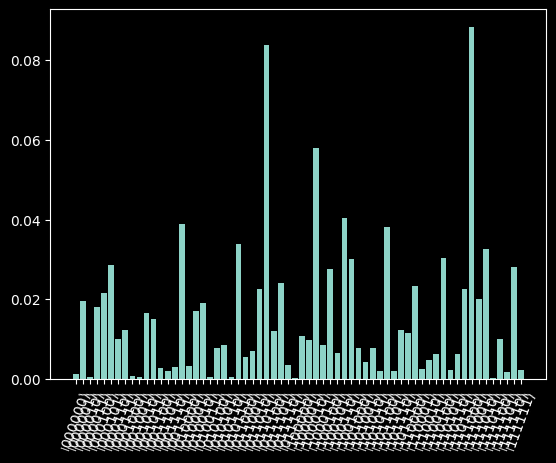

In [ ]:
print_output(c_final)


### Influence of different mixers

In [ ]:
# difine an universal QAOA ansatz
def QAOA_ansatz_mixer(params, nlayers, pauli_terms, weights, mixer="standard", gap=5):
    nqubits = len(pauli_terms[0])
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.h(i)
    for j in range(nlayers):
        # cost term
        for k in range(len(pauli_terms)):
            term = pauli_terms[k]
            index_of_ones = []
            for l in range(len(term)):
                if term[l] == 1:
                    index_of_ones.append(l)
            if len(index_of_ones) == 1:
                c.rz(index_of_ones[0], theta=2 * weights[k] * params[2 * j])
            elif len(index_of_ones) == 2:
                c.exp1(
                    index_of_ones[0],
                    index_of_ones[1],
                    unitary=tc.gates._zz_matrix,
                    theta=weights[k] * params[2 * j],
                )
            else:
                raise ValueError("Invalid number of Z terms")

        # standard mixer term
        if mixer == "standard":
            for i in range(nqubits):
                c.rx(i, theta=params[2 * j + 1])

        # XY mixer
        elif mixer == "ring":
            for i in range(nqubits - 1):
                c.exp1(i, i + 1, unitary=tc.gates._xx_matrix, theta=params[2 * j + 1])
                c.exp1(i, i + 1, unitary=tc.gates._yy_matrix, theta=params[2 * j + 1])
            c.exp1(nqubits - 1, 0, unitary=tc.gates._xx_matrix, theta=params[2 * j + 1])
            c.exp1(nqubits - 1, 0, unitary=tc.gates._yy_matrix, theta=params[2 * j + 1])

        # parity ring mixer
        elif mixer == "par_ring":
            half = int(np.floor(nqubits / 2))
            if 2 * half < nqubits:
                end = half
            else:
                end = half - 1
            for i in range(half):  # even
                c.exp1(2 * i, 2 * i + 1, unitary=tc.gates._xx_matrix, theta=params[2 * j + 1])
                c.exp1(2 * i, 2 * i + 1, unitary=tc.gates._yy_matrix, theta=params[2 * j + 1])
            for i in range(end):  # odd
                c.exp1(2 * i + 1, 2 * i + 2, unitary=tc.gates._xx_matrix, theta=params[2 * j + 1])
                c.exp1(2 * i + 1, 2 * i + 2, unitary=tc.gates._yy_matrix, theta=params[2 * j + 1])

        # full mixer
        elif mixer == "full":
            for i in range(nqubits - gap):
                c.exp1(i, i + gap, unitary=tc.gates._xx_matrix, theta=params[2 * j + 1])
                c.exp1(i, i + gap, unitary=tc.gates._yy_matrix, theta=params[2 * j + 1])
            for i in range(gap):
                c.exp1(nqubits - gap - 1 + i, 1 + gap, unitary=tc.gates._xx_matrix, theta=params[2 * j + 1])
                c.exp1(nqubits - gap - 1 + i, 1 + gap, unitary=tc.gates._yy_matrix, theta=params[2 * j + 1])
        #
        elif mixer == "QAMPA":
            pass

        else:
            raise RuntimeError("Invalid mixer name")
    return c

In [ ]:
def QAOA_loss_mixer(nlayers, pauli_terms, weights, params):
    c = QAOA_ansatz_mixer(params, nlayers, pauli_terms, weights, 'par_ring')
    return Ising_loss(c, pauli_terms, weights)

In [ ]:
iterations = 500
time_start = time.time()
final_params = QUBO_QAOA(Q, QAOA_loss_mixer, nlayers, iterations)
clear_output(wait=True)
time_end = time.time()
print("time consumed:", round(time_end - time_start, 4), "s")

time consumed: 8.9805 s


### Use CVaR

In [ ]:
def cvar_value(r, p, percent):
    rs = sorted(
        [(i, j) for i, j in enumerate(r)], key=lambda s: -s[1]
    )  # larger to smaller
    sump = 0.0  # the sum of probability
    count = 0
    cvar_result = 0.0
    while sump < percent:
        if round(sump + p[rs[count][0]], 7) >= percent:
            cvar_result += rs[count][1] * (percent - sump)
            count += 1
            break
        else:
            sump += p[rs[count][0]]
            cvar_result += rs[count][1] * p[rs[count][0]]
            count += 1

    cvar_result /= percent
    return K.real(cvar_result)

In [ ]:
def cvar_from_circuit(circuit, num_samples, Q, alpha):
    s = circuit.state()
    results = tc.quantum.measurement_results(
        s, counts=num_samples, format="count_dict_bin"
    )  # get readouts
    results = {k: v / num_samples for k, v in results.items()}
    values = []  # passed to cvar
    probability = []  # passed to cvar
    for k, v in results.items():
        x = np.array([int(bit) for bit in k])
        values.append(np.dot(x, np.dot(Q, x)))
        probability.append(v)
    cvar_result = cvar_value(values, probability, alpha)
    return cvar_result

In [ ]:
cvar_result = cvar_from_circuit(c_final, 1000, Q, 1)
print(cvar_result)


tf.Tensor(-1887.4656903255586, shape=(), dtype=float64)


In [ ]:
def cvar_loss(nlayers, Q, pauli_terms, weights, percent, params):
    c = QAOA_from_Ising(params, nlayers, pauli_terms, weights)
    return cvar_from_circuit(c, 1000, Q, percent)


In [ ]:
def QUBO_CVaR(Q, nlayers, alpha):
    pauli_terms, weights, offset = QUBO_to_Ising(Q)
    learning_rate = 1e-2

    loss = partial(cvar_loss, nlayers, Q, pauli_terms, weights, alpha)
    # value, COBYLA
    
    f_scipy = tc.interfaces.scipy_interface(loss, shape=[2 * nlayers], jit=False, gradient=False)
    params = K.implicit_randn(shape=[2 * nlayers], stddev=0.5)
    r = optimize.minimize(f_scipy, params, method="COBYLA")

    return r

In [ ]:
def QUBO_CVaR_vvag(Q, nlayers, alpha):
    pauli_terms, weights, offset = QUBO_to_Ising(Q)
    learning_rate = 1e-2

    cvar_vvag = tc.backend.vvag(cvar_loss, argnums=0, vectorized_argnums=0)
    ncircuits = 3
    params = K.implicit_randn(
        shape=[ncircuits, 2 * nlayers], stddev=0.1
    )  # initial parameters
    loss = partial(cvar_vvag, nlayers, Q, pauli_terms, weights, alpha)
    
    f_scipy = tc.interfaces.scipy_interface(loss, shape=[ncircuits,2 * nlayers], jit=False, gradient=False)
    #params = K.implicit_randn(shape=[2 * nlayers], stddev=0.5)
    r = optimize.minimize(f_scipy, params, method="COBYLA")

    return r

In [ ]:
# iterations = 500
time_start = time.time()
nlayers = 20
final_params = QUBO_CVaR(Q, nlayers, 0.6)
clear_output(wait=True)
time_end = time.time()
print("time consumed:", round(time_end - time_start, 4), "s")

time consumed: 134.7523 s


# probabilities

In [ ]:
"""alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
prob = [[]]
last_prob = 0
for i in alpha:
    single_prob = []
    for j in range(2):
        clear_output(wait=True)
        print('alpha', i)
        print('times', j)
        print('last prob', last_prob)
        result = QUBO_CVaR(Q, nlayers, i)
        c_final = QAOA_from_Ising(
            result.x, nlayers, portfolio_pauli_terms, portfolio_weights
        )
        probs = K.numpy(c_final.probability()).round(decimals=6)
        single_prob.append(probs[35])
        last_prob = probs[35]
        prob
    prob.append(single_prob)
clear_output(wait=True)
print(prob)"""

"alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]\nprob = [[]]\nlast_prob = 0\nfor i in alpha:\n    single_prob = []\n    for j in range(2):\n        clear_output(wait=True)\n        print('alpha', i)\n        print('times', j)\n        print('last prob', last_prob)\n        result = QUBO_CVaR(Q, nlayers, i)\n        c_final = QAOA_from_Ising(\n            result.x, nlayers, portfolio_pauli_terms, portfolio_weights\n        )\n        probs = K.numpy(c_final.probability()).round(decimals=6)\n        single_prob.append(probs[35])\n        last_prob = probs[35]\n        prob\n    prob.append(single_prob)\nclear_output(wait=True)\nprint(prob)"

# rankings

In [ ]:
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
total_rank = [[]]
last_rank = 0
n_layers = 15
for i in alpha:
    rank = []
    for j in range(20):
        clear_output(wait=True)
        print('alpha', i)
        print('times', j)
        print('rank', rank)
        print("total", total_rank)
        result = QUBO_CVaR(Q, nlayers, i)
        c_final = QAOA_from_Ising(
            result.x, nlayers, portfolio_pauli_terms, portfolio_weights
        )
        probs = K.numpy(c_final.probability()).round(decimals=6)
        prob35 = probs[35]
        loc = np.where(np.sort(probs)==prob35)
        rank.append(loc[0][0])
    total_rank.append(rank)
clear_output(wait=True)
print("total", total_rank)

total [[], [14, 56, 5, 5, 30, 28, 49, 19, 15, 37, 51, 41, 45, 38, 47, 62, 14, 26, 40, 34], [55, 16, 11, 28, 4, 42, 58, 44, 48, 48, 20, 61, 23, 13, 27, 2, 5, 35, 46, 6], [42, 36, 16, 39, 54, 27, 25, 4, 21, 19, 46, 50, 62, 41, 54, 58, 26, 52, 2, 17], [60, 30, 33, 18, 45, 60, 27, 24, 56, 63, 54, 32, 9, 13, 44, 51, 32, 9, 11, 43], [45, 63, 50, 44, 4, 37, 51, 42, 11, 10, 58, 50, 34, 35, 11, 24, 54, 30, 53, 57], [47, 59, 38, 57, 6, 59, 35, 0, 46, 48, 35, 21, 60, 44, 49, 32, 49, 58, 60, 20], [8, 24, 39, 61, 11, 56, 7, 54, 36, 53, 43, 53, 50, 5, 56, 63, 58, 41, 61, 21], [20, 36, 63, 26, 58, 48, 19, 49, 62, 20, 63, 57, 41, 57, 33, 42, 35, 53, 1, 51], [63, 45, 41, 60, 50, 57, 15, 44, 15, 48, 61, 39, 42, 21, 58, 12, 17, 30, 10, 48]]


In [ ]:
import pandas as pd
name = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
df = pd.DataFrame(total_rank[1:])
df.to_csv('rank.csv')

In [ ]:
prob5 = [[round(j, 5) for j in i] for i in prob]
print(prob5)

NameError: name 'prob' is not defined

In [ ]:
final_params.x
c_final = QAOA_from_Ising(
    final_params.x, nlayers, portfolio_pauli_terms, portfolio_weights
)
states = []
for i in range(2**n_stocks):
    a = f"{bin(i)[2:]:0>{n_stocks}}"
    states.append(a)
probs = K.numpy(c_final.probability()).round(decimals=6)
sorted_indices = np.argsort(probs)[::-1]
state_sorted = np.array(states)[sorted_indices]
prob_sorted = np.array(probs)[sorted_indices]

print("\n-------------------------------------")
print("    selection\t  |\tprobability")
print("-------------------------------------")
for i in range(len(states)):
    print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
print("-------------------------------------")

# Rewrite with Qiskit

1.0

In [ ]:
from qiskit import QuantumCircuit

ansatz = 

# Benchmarking